In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
from scipy import interpolate
from scipy import signal
from glob import glob
import scipy.ndimage
import matplotlib.colors as colors

from sklearn.linear_model import LinearRegression
import spectrum as spec
from numpy import fft

#import spectrum
plt.rcParams['figure.figsize'] = (15,10)

#data directory for saildrone data
#more on the data here: https://podaac.jpl.nasa.gov/dataset/SAILDRONE_ATOMIC
# DOI = 10.5067/SDRON-ATOM0
data_dir = './data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#output
figs_dir = './figures/'

# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [2]:
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()
  
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat, xlon = ds_usv.latitude, ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')
ds_saildrone = ds.copy(deep=True)


In [3]:

var = 'density_mean'
dt = 0.08  #set sampling interpolation to 80m
data = ds_saildrone
ps_all_fft,ps_all_mt,ps_all_per=[],[],[]
mindist = int(data.dist_total.max(dim='time').min().data-1)
print(mindist)

for iusv in range(3):
    
    #read in saildrone data, make coordinatin system total distance from start
    #interpolate onto regular distances
    #detrend
    ds_usv = data.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    ds3 = ds3.sel(dist_total=slice(0,mindist))        
    dist_interp = np.arange(ds2.dist_total[0],mindist,dt)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4[var].interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    N = len(den)
    print(N)
    ds4_detrend = signal.detrend(den)  

    # classical FFT
    yf = fft.fft(ds4_detrend)
    xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
    ps_all_fft.append(yf[0:34700])

    #periodogram
    per_freq, Pxx_den = signal.periodogram(ds4_detrend,1/dt)  #fs = sampled at .08km or 80m
    ps_all_per.append(yf[0:34700])
    
    #multitaper
    NW,k=2.5,4
    [tapers, eigen] = spec.dpss(N, NW, k)
    Sk_complex, weights, eigenvalues=spec.pmtm(ds4_detrend, e=eigen, v=tapers, NFFT=N, show=False)
    # The multitapered method
    Sk = abs(Sk_complex)**2
    Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
    ps_all_mt.append(Sk[0:34700])
    
sfft,sper,smt = np.mean(np.vstack(ps_all_fft),axis=0),np.mean(np.vstack(ps_all_per),axis=0),np.mean(np.vstack(ps_all_mt),axis=0)


5551
69386
69386
69386


# make figure

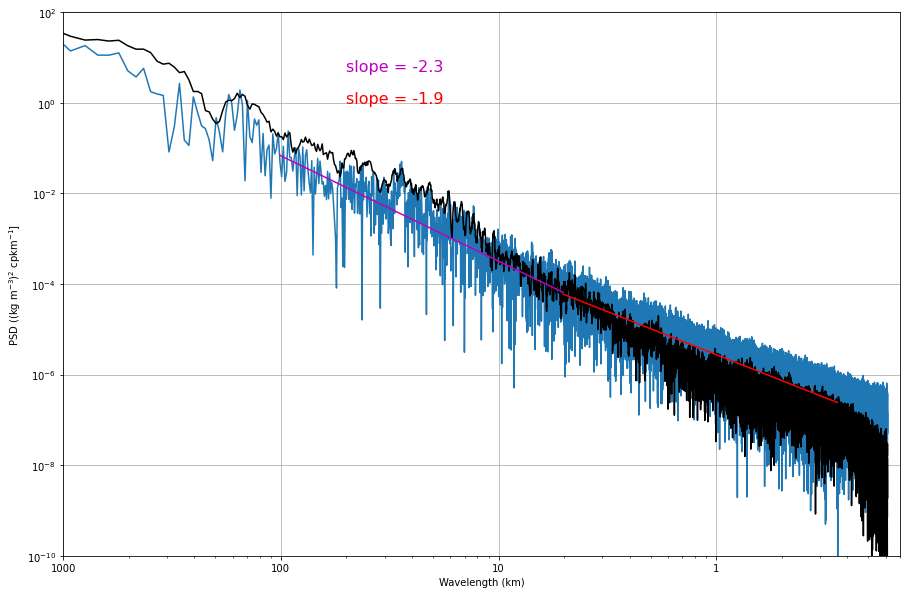

In [4]:
iend = 34000
plt.loglog(xf[0:iend],abs(sper[0:iend])**2 / N * dt)
plt.loglog(xf[0:iend],smt[0:iend],'k')

#iline=1/28
#plt.axvline(iline,c='g')

istart,iend=55,1100
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'m') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,5,slp_str,fontsize=16,color='m')

istart,iend=1100,20000
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,1,slp_str,fontsize=16,color='r')

plt.xlim([10e-4,7])
plt.ylim([10e-11,10e1])
plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])
plt.xlabel('Wavelength (km)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
plt.grid()
plt.savefig('./figures/PSD_den_grad_usv_multitaper.png')


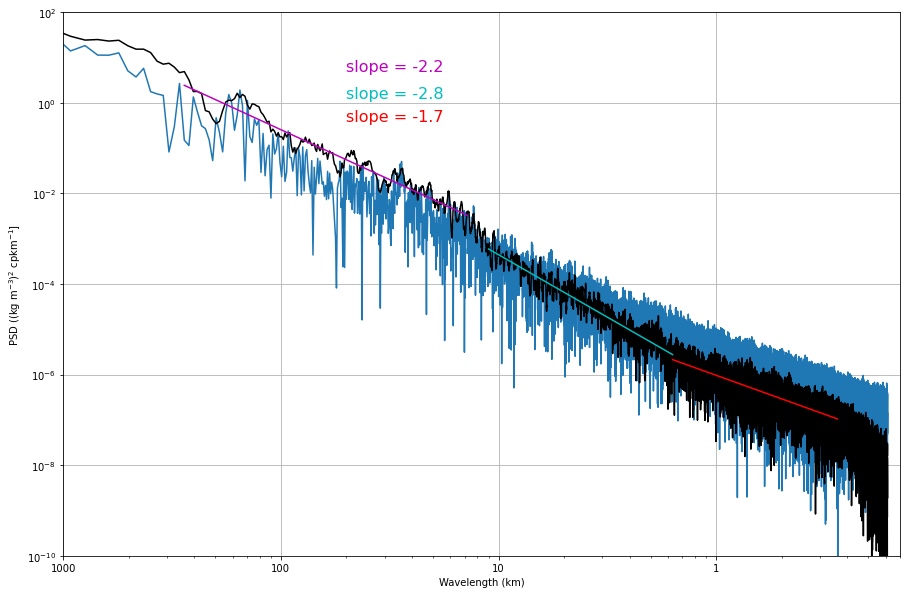

In [5]:

iend = 34000
plt.loglog(xf[0:iend],abs(sper[0:iend])**2 / N * dt)
plt.loglog(xf[0:iend],smt[0:iend],'k')

#iline=1/28
#plt.axvline(iline,c='g')

istart,iend=20,400
XX = np.log(xf[istart:iend])
YY = np.log(abs(smt[istart:iend]))
#YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'m') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,5,slp_str,fontsize=16,color='m')

istart,iend=500,3500
XX = np.log(xf[istart:iend])
#YY = np.log(abs(sper[istart:iend])**2 / N * dt)
YY = np.log(abs(smt[istart:iend]))
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'c') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,1.3,slp_str,fontsize=16,color='c')

istart,iend=3500,20000
XX = np.log(xf[istart:iend])
#YY = np.log(abs(sper[istart:iend])**2 / N * dt)
YY = np.log(abs(smt[istart:iend]))
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,.4,slp_str,fontsize=16,color='r')

plt.xlim([10e-4,7])
plt.ylim([10e-11,10e1])
plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])
plt.xlabel('Wavelength (km)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
plt.grid()
plt.savefig('./figures/PSD_usv_multitaper.png')


In [6]:
#print out different wavelengths
print(1/xf[20000], 1/xf[55])
print(1/xf[5500], 1/xf[55])
print(1/xf[5500], 1/xf[1100])
print(1/xf[1100], 1/xf[55])

0.277536 100.92218181818183
1.0092218181818182 100.92218181818183
1.0092218181818182 5.046109090909091
5.046109090909091 100.92218181818183


Text(0.02, 1, 'slope = -1.9')

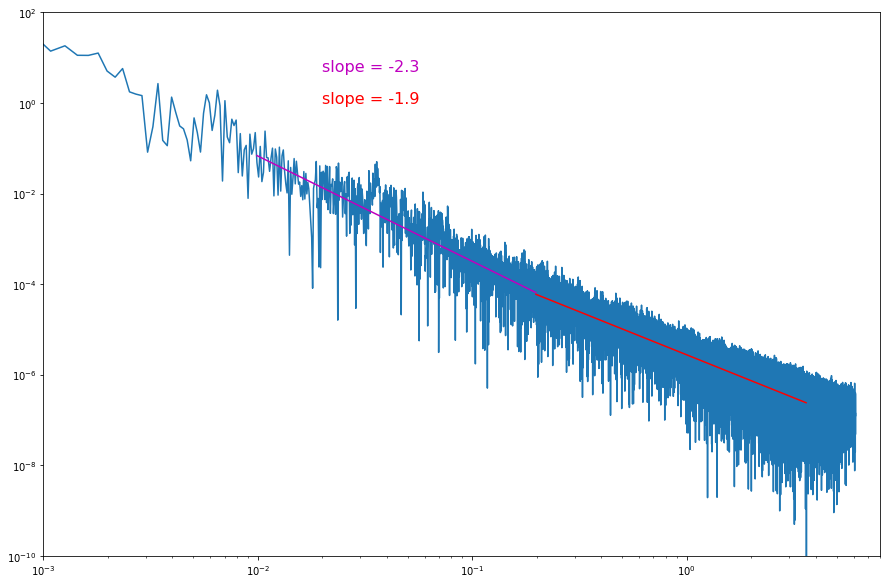

In [7]:
iend=34000
plt.loglog(xf[0:iend],abs(sper[0:iend])**2 / N * dt)
plt.xlim([10e-4,8])
plt.ylim([10e-11,10e1])
plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])
istart,iend=55,1100
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'m') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,5,slp_str,fontsize=16,color='m')

istart,iend=1100,20000
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,1,slp_str,fontsize=16,color='r')


# Time spectrum

66240
66240
66240


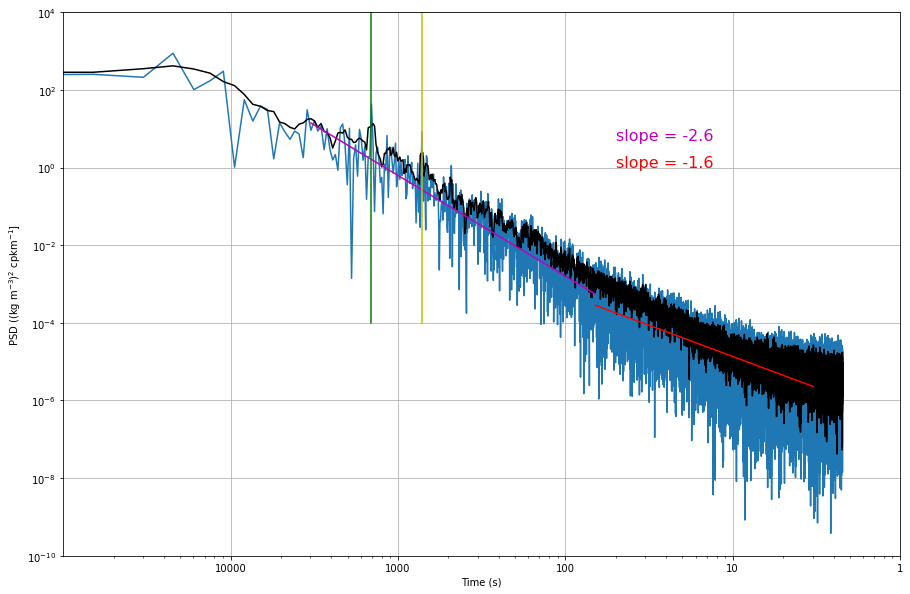

In [8]:

var = 'TEMP_SBE37_MEAN'
#var = 'TEMP_AIR_MEAN'
dt = 1  #set sampling interpolation to 80m
data = ds_saildrone
ps_all_fft,ps_all_mt,ps_all_per=[],[],[]
#mindist = int(data.dist_total.max(dim='time').min().data-1)
#print(mindist)

for iusv in range(3):
    
    #read in saildrone data, make coordinatin system total distance from start
    #interpolate onto regular distances
    #detrend
    ds_usv = data.isel(trajectory=iusv)
    
    #den = ds_usv[var].interpolate_na(dim='time')
    #den = den.where(np.isfinite(den),drop=True)
    #ds4_detrend_smooth = signal.detrend(den)

    
    #ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    #ds3 = ds2.swap_dims({'time':'dist_total'})
    #ds3 = ds3.sel(dist_total=slice(0,mindist))        
    #dist_interp = np.arange(ds2.dist_total[0],mindist,dt)
    #ds4 = ds3.interp(dist_total=dist_interp)
    den = ds_usv[var].interpolate_na(dim='time')
    den = den.where(np.isfinite(den),drop=True)
    N = len(den)
    print(N)
    ds4_detrend = signal.detrend(den)  

    # classical FFT
    yf = fft.fft(ds4_detrend)
    xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
    ps_all_fft.append(yf[0:34700])

    #periodogram
    per_freq, Pxx_den = signal.periodogram(ds4_detrend,1/dt)  #fs = sampled at .08km or 80m
    ps_all_per.append(yf[0:34700])
    
    #multitaper
    NW,k=2.5,4
    [tapers, eigen] = spec.dpss(N, NW, k)
    Sk_complex, weights, eigenvalues=spec.pmtm(ds4_detrend, e=eigen, v=tapers, NFFT=N, show=False)
    # The multitapered method
    Sk = abs(Sk_complex)**2
    Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
    ps_all_mt.append(Sk[0:34700])
    
sfft,sper,smt = np.mean(np.vstack(ps_all_fft),axis=0),np.mean(np.vstack(ps_all_per),axis=0),np.mean(np.vstack(ps_all_mt),axis=0)

iend = 30000
plt.loglog(xf[0:iend],abs(sper[0:iend])**2 / N * dt)
plt.loglog(xf[0:iend],smt[0:iend],'k')

#iline=1/28
#plt.axvline(iline,c='g')

istart,iend=20,1000
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'m') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,5,slp_str,fontsize=16,color='m')

istart,iend=1000,20000
XX = np.log(xf[istart:iend])
YY = np.log(abs(sper[istart:iend])**2 / N * dt)
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(xf[istart:iend], xf[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,1,slp_str,fontsize=16,color='r')

plt.loglog([1/(60*12),1/(60*12)],[10e-5,10e4],'y')
plt.loglog([1/(60*24),1/(60*24)],[10e-5,10e4],'g')
#plt.loglog(freq[0:1000], Pxx_den[0:1000],'b')

plt.xlim([10e-6,1])
plt.ylim([10e-11,10e3])
plt.xticks(ticks=[.0001,.001,.01,.1,1],labels=['10000','1000','100','10','1'])
plt.xlabel('Time (s)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
plt.grid()
plt.savefig('./figures/PSD_den_grad_usv_multitaper_time.png')
